<font size="4">
Use this notebook to run inference on HLS_model & Keras UNet_lite from: <br> 
<code><font size="3.5">
Models/model_for_hls.py <br>
</font></code> as it works with its architecture and functional API. <br><br>
Change as required for your setup:
<ul>
  <li><code>gpu = gpus[#GPU]</code> Choose #GPU to run training on, can copy and paste notebook and train on different GPUs simultaneously</li>
  <li><code>data_dir =</code> Specify path to .root files</li>
  <li><code>start_idx/end_idx = </code> Which events to test on (make different to training events)</li>
  <li><code>dataset = Dataset(..., save = True/False,...</code> Use True for 1st run through to create .npy files, False after </li>
  <li><code>testEvent = </code> Choose a number, images from will be displayed </li>
  <li><code>saturation_value = </code> Choose detector saturation</li>
  <li><code>strip_size = </code> Choose from either 'strip' or 'full_image'</li>
  <li><code>batch_size = </code>Choose sensible number to not overcommit VRAM GPU memory</li>
  <li><code>from Models.</code> FILE </code><code> import ModelConfig, TrainingConfig</code>  Specify FILE of which model architecture from list of .py files above</li>
</ul>
</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hls4ml
import os
from tensorflow.keras.models import load_model
import tensorflow as tf
import json
from tqdm.notebook import tqdm
from data_processing import Dataset
from noise import NoiseScheduler
import random

seed = 22
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the device to custom GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
gpu = gpus[1] # Specify which gpu to use here. Can run multiple scripts on different GPUs
if gpu:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpu, 'GPU')
        print("CUDA is available!")
        print("Number of available GPUs:", len(gpus))
        print("Current GPU:", gpu)
    except RuntimeError as e:
        print(e)
else:
    print("CUDA is not available. Running on CPU.")

2024-07-31 19:05:17.875954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CUDA is available!
Number of available GPUs: 6
Current GPU: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [2]:
# Set to directory where data is stored
work_home = True
data_dir = "../Datasets" if work_home else "/cephfs/dice/projects/L1T/diffusion/datasets/"
import os
print(os.getcwd())

start_idx = 12000 # Adjust which events to look at from the dataset, make different to the training data 
end_idx = 12300
dataset = Dataset(end_idx-start_idx, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False, start_idx=start_idx, end_idx=end_idx) # 120 eta, 72 phi

/storage/sa21722/stablediffusion/keras_version


In [3]:
dataset() #once this is cached, you don't have to re-load

INFO:root:Loading .npy files from /storage/sa21722/stablediffusion/keras_version/signal.npy and /storage/sa21722/stablediffusion/keras_version/pile_up.npy


Show original shape of image to determine which axis corresponds to eta and phi:

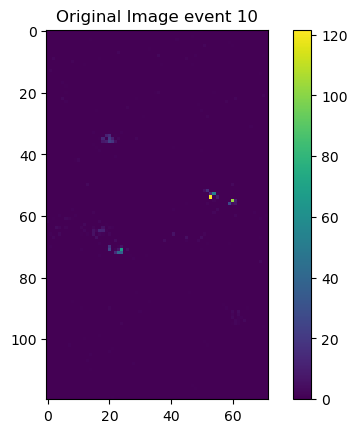

In [4]:

# Select an index for the image you want to visualize
testEvent = 10  # Change this to visualize a different image

# Access the original image from the dataset
original_image = dataset.signal[testEvent]

# Display the original image using matplotlib
plt.imshow(original_image)
plt.colorbar()
plt.title(f"Original Image event {testEvent}")
plt.show()


In [5]:
new_dim=(64,64)

saturation_value = 512 # Change saturation value here (make same as training value)
dataset.preprocess(new_dim)     # ensure these have the same values as when the model was trained

INFO:root:Re-sizing tensors...


In [6]:
# Extract horizontal strip from y=26 to y=38 (12 pixels tall)
# Change how much of image to train model on here
strip_size = 'full_image'

# Change size of strip here
strip_top = 26
strip_bottom = 38

MSE_y_start = strip_top
MSE_y_end = strip_bottom

if strip_size == 'strip':
    y_start = strip_top
    y_end = strip_bottom
    
elif strip_size == 'full_image':
    y_start = 0
    y_end = 64

In [7]:
# Convert data to TensorFlow tensors
clean_frames = tf.convert_to_tensor(dataset.signal, dtype=tf.float32)[:, y_start:y_end, :]
pile_up = tf.convert_to_tensor(dataset.pile_up, dtype=tf.float32)[:, y_start:y_end, :]

# Normalize data
clean_frames = tf.clip_by_value(clean_frames, 0, saturation_value)
pile_up = tf.clip_by_value(pile_up, 0, saturation_value)

# Reshape data
clean_frames = tf.expand_dims(clean_frames, axis=-1)
pile_up = tf.expand_dims(pile_up, axis=-1)

print(clean_frames.shape)

2024-07-31 19:05:25.563729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(300, 64, 64, 1)


2024-07-31 19:05:25.810800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:21:00.0, compute capability: 7.5


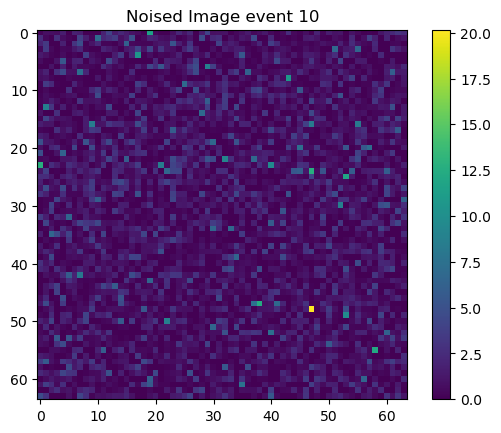

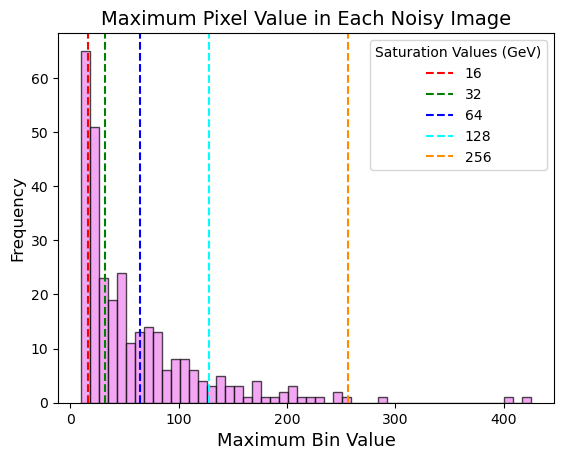

Threshold (GeV)      Perc of Events Above Threshold(%)
16                   82.00                    
32                   56.00                    
64                   33.33                    
128                  11.67                    
256                  1.33                     
512                  0.00                     


In [8]:
batch_size = 100
dataloader = tf.data.Dataset.from_tensor_slices(clean_frames).batch(batch_size)

# Create noise scheduler
noise_scheduler = NoiseScheduler('pile-up')

# Each unit of timestep represents an additional 5 pile-up events (max 40 = 200PU)
timestep = tf.convert_to_tensor(40)

# Initialize the array to hold the maximum pixel values
noisy_max_bin = np.zeros(end_idx - start_idx)

# Loop through the DataLoader
for batch_idx, clean_batch in enumerate(dataloader):
    random_seed = np.random.randint(0, end_idx - start_idx)

    # Generate the noisy image at maxTimestep (200 pile-ups)
    noisy_images, noise = noise_scheduler.add_noise(
        clean_frame=clean_batch, 
        noise_sample=pile_up, 
        timestep=timestep, 
        random_seed=random_seed, 
        n_events=end_idx - start_idx
    )

    # Update the maximum pixel values
    batch_start = batch_idx * batch_size # GOT TO HERE
    batch_end = batch_start + clean_batch.shape[0]
    
    # Calculate the maximum pixel value for each image in the batch
    noisy_max_bin[batch_start:batch_end] = tf.reduce_max(tf.reshape(noisy_images, (noisy_images.shape[0], -1)), axis=1).numpy()

    # Visualize one image from the batch (e.g., the first image in the batch)
    if batch_idx == 0:  # Adjust condition to visualize other batches if needed
        plt.imshow(noisy_images[testEvent].numpy().squeeze())
        plt.colorbar()
        plt.title(f"Noised Image event {testEvent}")
        plt.show()

# Plot histogram to see distribution of maximum pixel value in each event
plt.hist(noisy_max_bin, bins=50, color='violet', alpha=0.7, edgecolor='black')
plt.title('Maximum Pixel Value in Each Noisy Image', fontsize=14)
plt.xlabel('Maximum Bin Value', fontsize=13)
plt.ylabel('Frequency', fontsize=12)
# Plot vertical lines at x values of 16, 32, 64
plt.axvline(x=16, color='r', linestyle='--', label='16')
plt.axvline(x=32, color='green', linestyle='--', label='32')
plt.axvline(x=64, color='blue', linestyle='--', label='64')
plt.axvline(x=128, color='cyan', linestyle='--', label='128')
plt.axvline(x=256, color='darkorange', linestyle='--', label='256')

# Add legend
plt.legend(title='Saturation Values (GeV)')
plt.show()

# Calculate the percentage of events with maximum pixel value greater than given thresholds
thresholds = [16, 32, 64, 128, 256, 512]
percentages = [(noisy_max_bin > threshold).sum() / len(noisy_max_bin) * 100 for threshold in thresholds]

# Print the table
print(f"{'Threshold (GeV)':<20} {'Perc of Events Above Threshold(%)':<25}")
for threshold, percentage in zip(thresholds, percentages):
    print(f"{threshold:<20} {percentage:<25.2f}")

In [9]:
noisy_image, noise = noise_scheduler.add_noise(clean_frame=tf.expand_dims(clean_frames[testEvent], 0), noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)
# Apply saturation value clipping
noisy_image = tf.clip_by_value(noisy_image, 0, saturation_value)


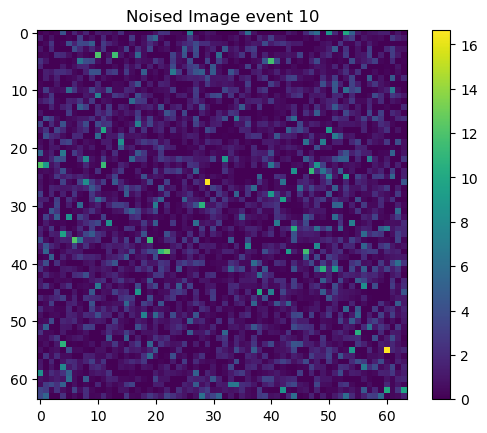

In [10]:
plt.imshow(noisy_image[0])
plt.colorbar()
plt.title(f"Noised Image event {testEvent}")
plt.show()

In [11]:
# Import the keras model
keras_model_path = "/storage/sa21722/stablediffusion/keras_version/hls_outputs/keras_model.h5"
try:
    keras_model = load_model(keras_model_path)
    print(keras_model.summary())
except Exception as e:
    print(f"Error loading Keras model: {e}")

Model: "UNetLite_hls"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pos_enc_main (InputLayer)      [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 input_images (InputLayer)      [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 emb1 (Dense)                   (None, 64, 64, 1)    5           ['pos_enc_main[0][0]']           
                                                                                                  
 add (Add)                      (None, 64, 64, 1)    0           ['input_images[0][0]',           
                                                                  'emb1[0][0]']        

Interpreting Model
Topology:
Layer name: pos_enc_main, layer type: InputLayer, input shapes: [[None, 64, 64, 4]], output shape: [None, 64, 64, 4]
Layer name: input_images, layer type: InputLayer, input shapes: [[None, 64, 64, 1]], output shape: [None, 64, 64, 1]
Layer name: emb1, layer type: Dense, input shapes: [[None, 64, 64, 4]], output shape: [None, 64, 64, 1]
Layer name: add, layer type: Merge, input shapes: [[None, 64, 64, 1], [None, 64, 64, 1]], output shape: [None, 64, 64, 1]
Layer name: convd1_1, layer type: Conv2D, input shapes: [[None, 64, 64, 1]], output shape: [None, 64, 64, 4]
Layer name: normd1_1, layer type: BatchNormalization, input shapes: [[None, 64, 64, 4]], output shape: [None, 64, 64, 4]
Layer name: relu_1, layer type: Activation, input shapes: [[None, 64, 64, 4]], output shape: [None, 64, 64, 4]
Layer name: convd1_2, layer type: Conv2D, input shapes: [[None, 64, 64, 4]], output shape: [None, 64, 64, 4]
Layer name: normd1_2, layer type: BatchNormalization, input s

2024-07-31 19:05:40.319199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-07-31 19:05:40.402614: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Recompiling myproject with tracing
Writing HLS project
Done


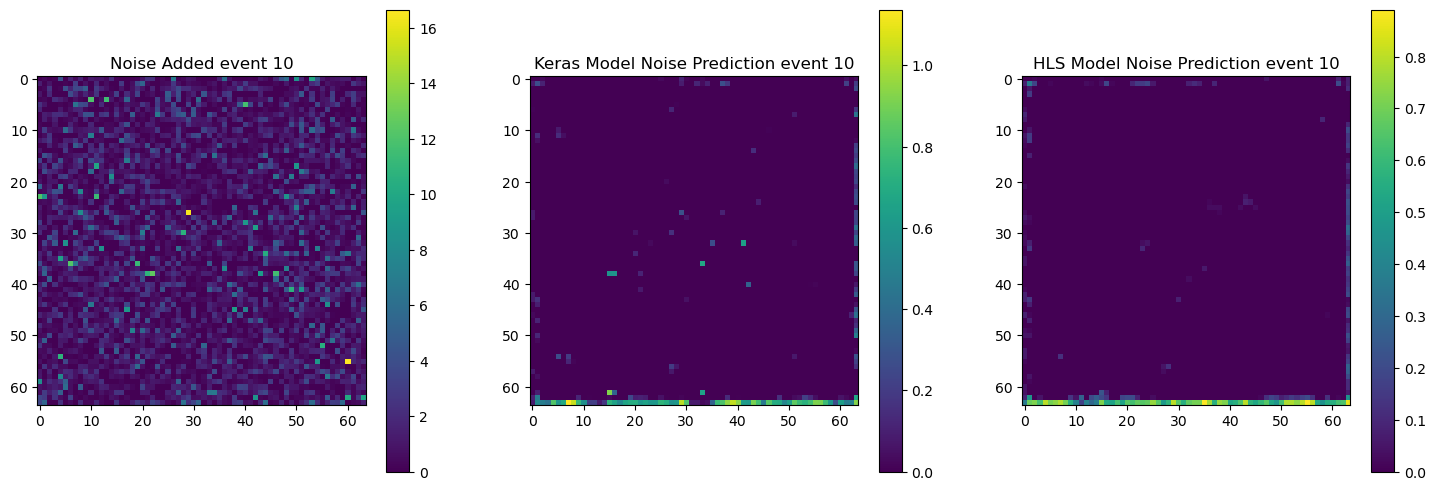

In [12]:
from Models.model_for_hls import positional_encoding


# Define the path to your HLS output directory and model
hls_output_dir = "hls_outputs"

try:
    # Load the HLS configuration
    with open(f"{hls_output_dir}/config.json", "r") as config_file: # change to config_final.json
        hls_config = json.load(config_file)

    # Reload the HLS model using the configuration
    hls_model = hls4ml.converters.convert_from_keras_model(keras_model,
                                                        hls_config=hls_config,
                                                        output_dir="hls_outputs_inference",
                                                        part='xcvu9p-flga2577-2-e',
                                                        clock_period=2.78,  # Assuming clock frequency of 360 MHz
                                                        io_type='io_stream')

    # Compile the HLS model
    hls_model.compile()

except Exception as e:
    print(f"Error loading Keras model: {e}")

# Function to perform denoising inference using the HLS model
def pred_with_hls_model(hls_model, noisy_image, pos_encoding, pos_encoding_bottleneck):

    # Ensure inputs are numpy arrays
    noisy_image = np.asarray(noisy_image)
    pos_encoding = np.asarray(pos_encoding)
    pos_encoding_bottleneck = np.asarray(pos_encoding_bottleneck)

    # Perform inference
    y_hls, _ = hls_model.trace([noisy_image, pos_encoding, pos_encoding_bottleneck])
    y_hls = y_hls.reshape(noisy_image.shape)
    return y_hls

def pred_with_keras_model(keras_model, noisy_image, pos_encoding, pos_encoding_bottleneck):
    y_keras = keras_model.predict([noisy_image, pos_encoding, pos_encoding_bottleneck], verbose=0)
    return  y_keras


# Prepare your noisy images and positional encodings
timestep = tf.convert_to_tensor(40)
pos_encoding = positional_encoding(timestep, 1, new_dim, 4, 5000)
pos_encoding_bottleneck = positional_encoding(timestep, 1, (int(new_dim[0]/2), int(new_dim[1]/2)), 4, 5000)

# Perform denoising inference
keras_pred = pred_with_keras_model(keras_model, noisy_image, pos_encoding, pos_encoding_bottleneck)
hls_pred = pred_with_hls_model(hls_model, noisy_image, pos_encoding, pos_encoding_bottleneck)

# Calculate the min and max values for setting the color scale
# vmin = min(keras_pred.min(), hls_pred.min(), noise.numpy().min())
# vmax = max(keras_pred.max(),hls_pred.max(), noise.numpy().max())

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Display the noise added
im1 = axes[0].imshow(noise[0])
axes[0].set_title(f"Noise Added event {testEvent}")
fig.colorbar(im1, ax=axes[0])

# Display the keras noise prediction
im2 = axes[1].imshow(keras_pred[0])#, vmin=vmin, vmax=vmax)
axes[1].set_title(f"Keras Model Noise Prediction event {testEvent}")
fig.colorbar(im2, ax=axes[1])

# Display the hls noise prediction
im3 = axes[2].imshow(hls_pred[0])#, vmin=vmin, vmax=vmax)
axes[2].set_title(f"HLS Model Noise Prediction event {testEvent}")
fig.colorbar(im3, ax=axes[2])

plt.show()


In [13]:
keras_denoised = tf.nn.relu(noisy_image - keras_pred)
hls_denoised = tf.nn.relu(noisy_image - hls_pred)

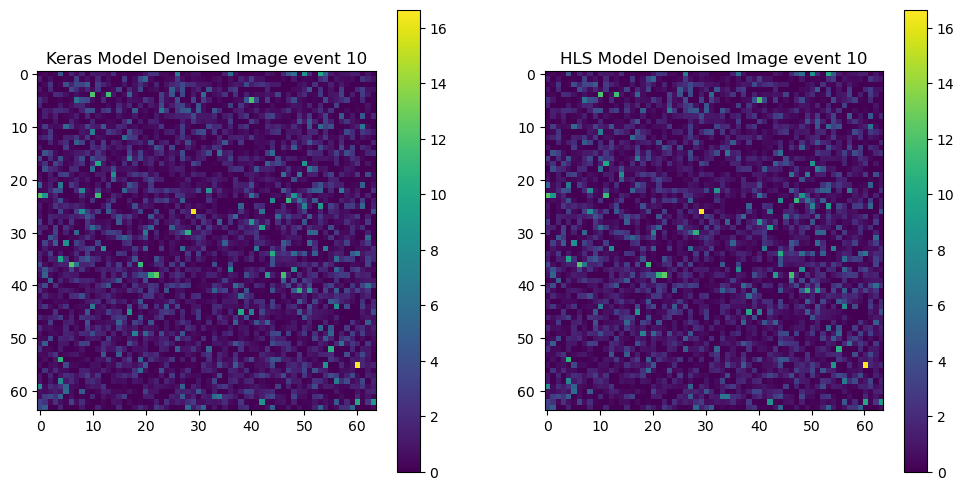

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the keras denoised image
im1 = axes[0].imshow(keras_denoised[0])
axes[0].set_title(f"Keras Model Denoised Image event {testEvent}")
fig.colorbar(im1, ax=axes[0])

# Display the HLS denoised image
im2 = axes[1].imshow(hls_denoised[0])
axes[1].set_title(f"HLS Model Denoised Image event {testEvent}")
fig.colorbar(im1, ax=axes[1])

plt.show()

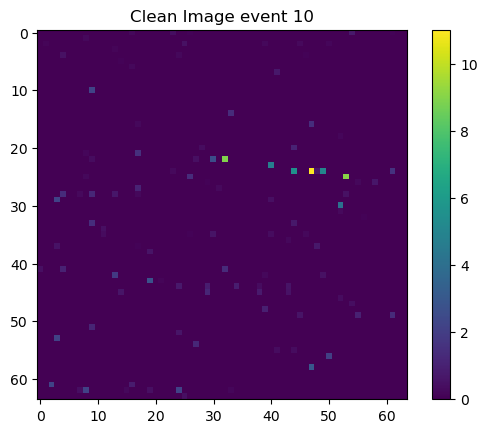

In [15]:
im = plt.imshow(clean_frames[testEvent])
plt.colorbar(im)
plt.title(f"Clean Image event {testEvent}")
plt.show()

In [16]:
keras_err = clean_frames[testEvent] - keras_denoised
hls_err = clean_frames[testEvent] - hls_denoised
print(f"Keras Model MSE for event {testEvent}: {np.mean((keras_err.numpy())**2)}")
print(f"HLS Model MSE for event {testEvent}: {np.mean((hls_err.numpy())**2)}")


Keras Model MSE for event 10: 3.975877046585083
HLS Model MSE for event 10: 3.9866514205932617


  0%|          | 0/123 [00:00<?, ?it/s]

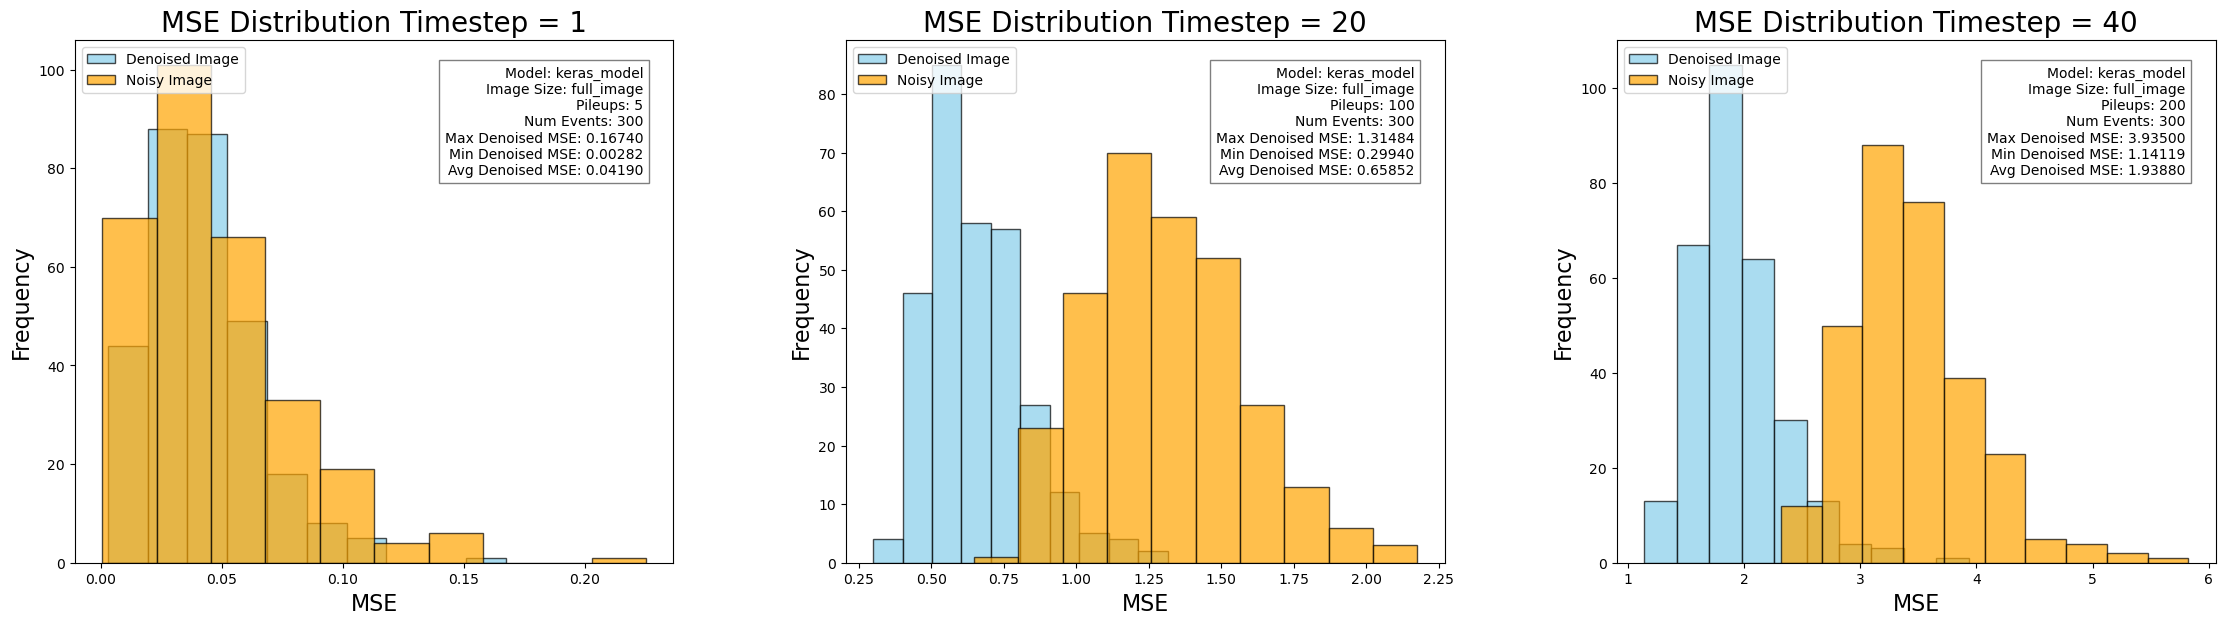

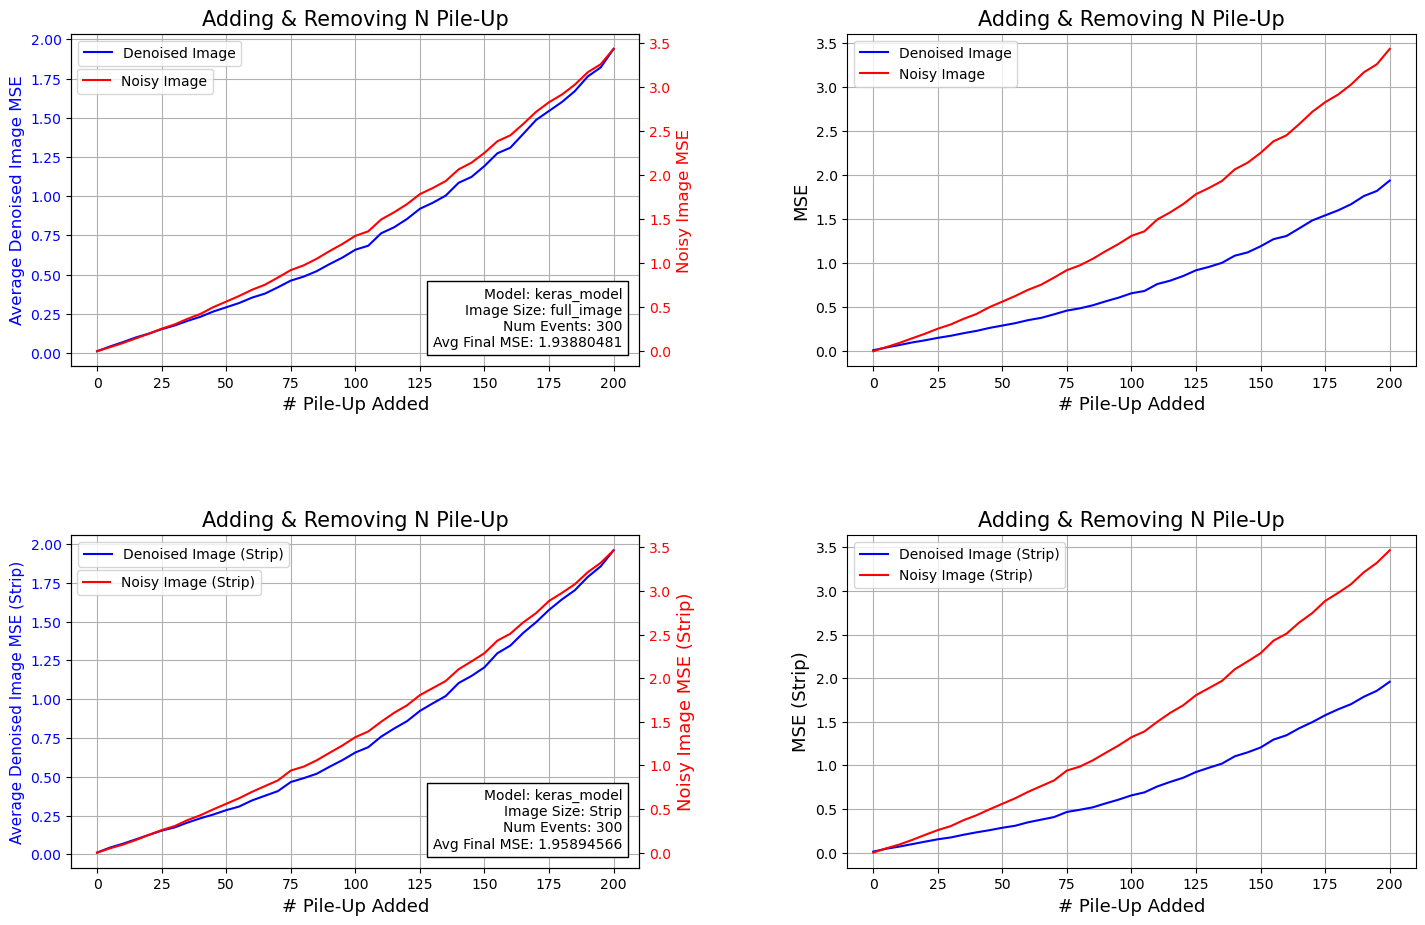

  0%|          | 0/123 [00:00<?, ?it/s]

Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Recompiling myproject with tracing
Writi

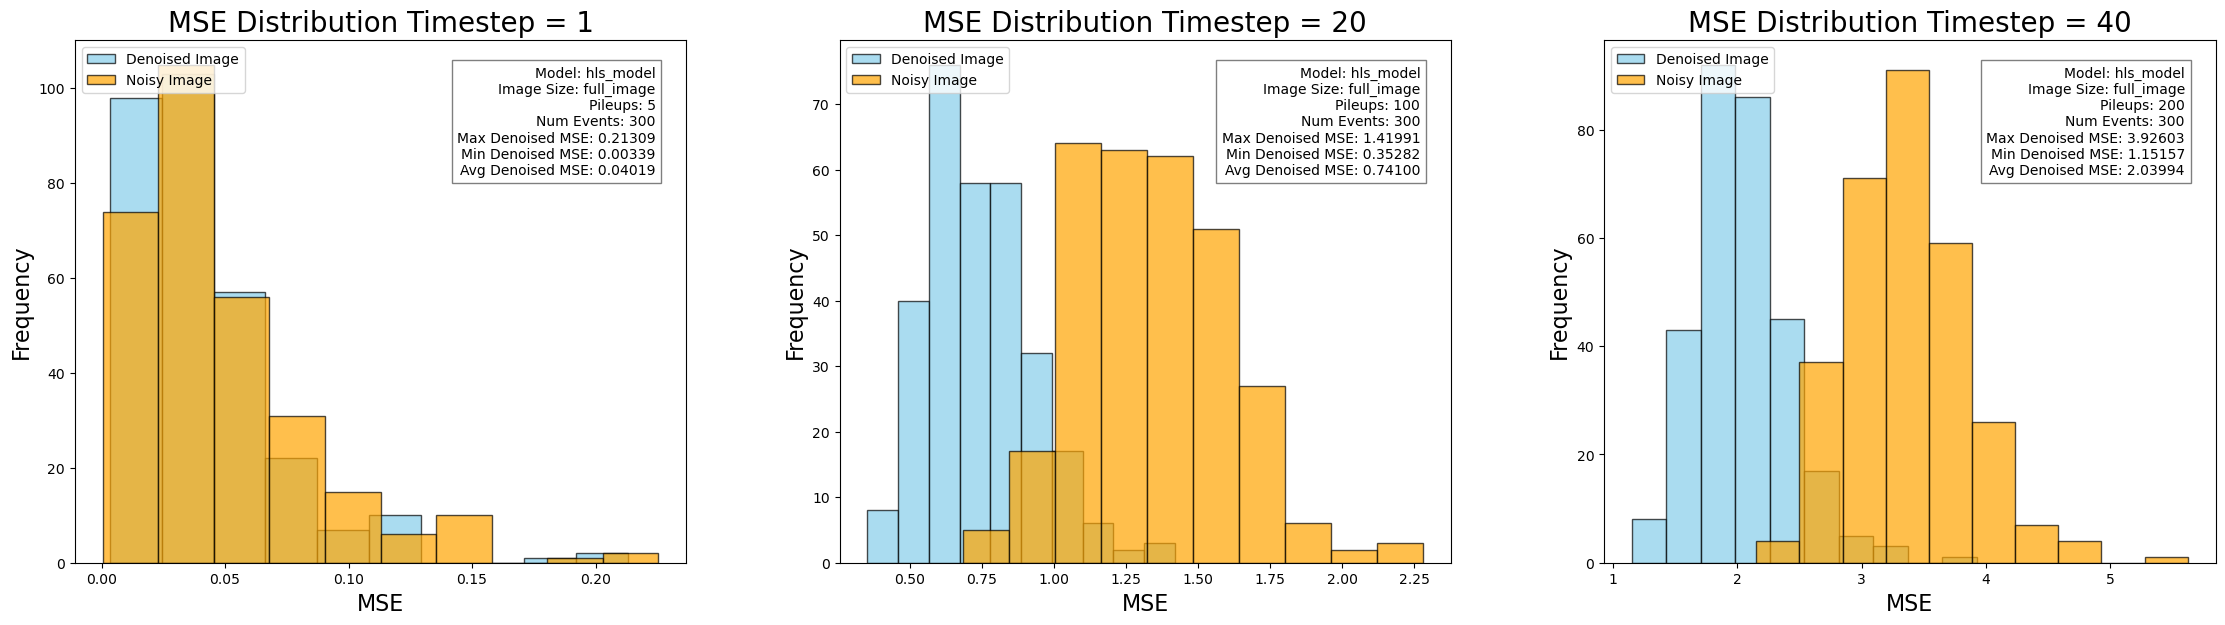

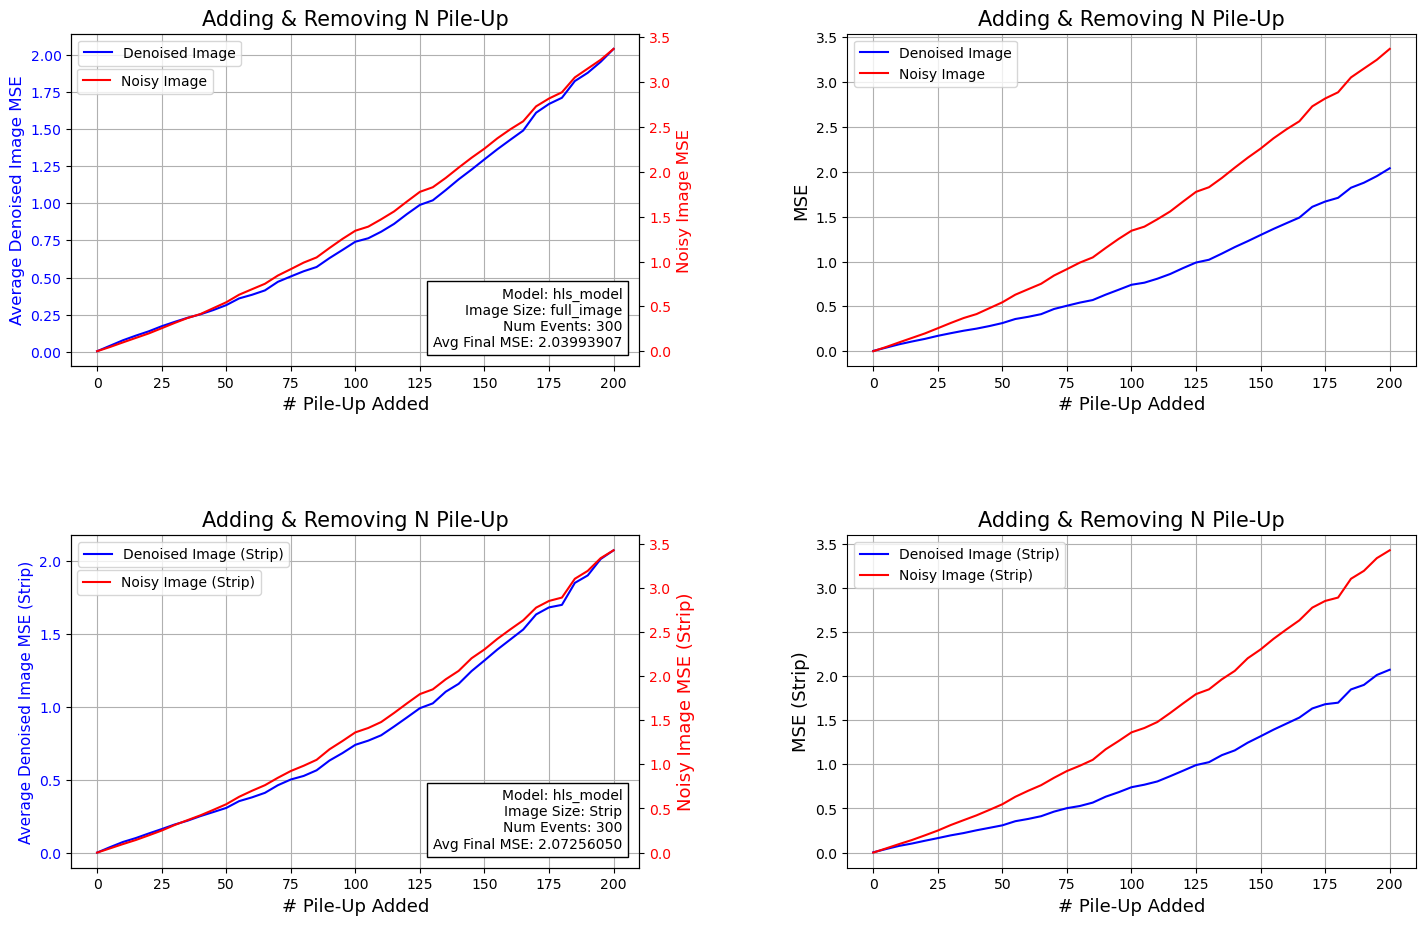

In [17]:
# Parameters
timesteps = np.linspace(0, 40, 41)  # Which timesteps to perform denoising at
num_events = end_idx - start_idx  # Number of trials where denoising process is performed and evaluated
batch_size = 100  # Adjust as needed
num_batches = num_events // batch_size

def inference_graphs(timesteps, num_events, batch_size, num_batches, model):
    global_step = 0
    # Create arrays to hold MSEs for each event at each timestep
    denoised_results = np.zeros((len(timesteps), num_batches, batch_size))  # For MSEs between denoised image and clean image
    denoised_results_strip = np.zeros((len(timesteps), num_batches, batch_size))
    noisy_results = np.zeros((len(timesteps), num_batches, batch_size))  # For MSEs between noisy image and clean image
    noisy_results_strip = np.zeros((len(timesteps), num_batches, batch_size))

    # Define DataLoader for inference batches
    inference_dataset = tf.data.Dataset.from_tensor_slices(clean_frames).batch(batch_size)

    # Define the progress bar
    progress_bar = tqdm(total=num_batches*len(timesteps))
    progress_bar.set_description(f"Inference ({model})")

    # Add a specific amount of noise at each timestep
    for idx, timestep_value in enumerate(timesteps):  # pairs up values of timesteps (=timestep_value) with their indexes(=idx)
   
        timestep = tf.convert_to_tensor(timestep_value, dtype=tf.int32)
        pos_encoding = positional_encoding(timestep, batch_size, new_dim, 4, 5000) * 0.01
        pos_encoding_bottleneck = positional_encoding(timestep, batch_size, (int(new_dim[0]/2), int(new_dim[1]/2)), 4, 5000) * 0.01
        
        # Run the denoising process a number of times
        for batch_idx, clean_batch in enumerate(inference_dataset):
            
            random_seed = np.random.randint(0, end_idx - start_idx)

            # Create noisy image and noise prediction
            noisy_images, noise = noise_scheduler.add_noise(
                clean_frame=clean_batch,
                noise_sample=pile_up,
                timestep=timestep,
                random_seed=random_seed,
                n_events=end_idx - start_idx
            )

            # Apply saturation value clipping and scaling
            noisy_images = tf.clip_by_value(noisy_images, 0, saturation_value)

            if model == 'hls_model':
                noise_pred = pred_with_hls_model(hls_model, noisy_images, pos_encoding, pos_encoding_bottleneck)

            elif model == 'keras_model':
                noise_pred = pred_with_keras_model(keras_model, noisy_images, pos_encoding, pos_encoding_bottleneck)

            else:
                print('Invalid Model Name')
                
            de_noised = tf.nn.relu(noisy_images - noise_pred)

            # Calculate the difference between denoised image and clean image
            denoised_err = clean_batch - de_noised
            denoised_MSE = tf.reduce_mean(tf.square(denoised_err), axis=[1, 2, 3])
            denoised_results[idx, batch_idx] = denoised_MSE.numpy()
            denoised_MSE_strip = tf.reduce_mean(tf.square(denoised_err[:, MSE_y_start:MSE_y_end, :, :]), axis=[1, 2, 3])
            denoised_results_strip[idx, batch_idx] = denoised_MSE_strip.numpy()

            # Calculate the difference between noisy image and clean image
            noisy_err = clean_batch - noisy_images
            noisy_MSE = tf.reduce_mean(tf.square(noisy_err), axis=[1, 2, 3])
            noisy_results[idx, batch_idx] = noisy_MSE.numpy()
            noisy_MSE_strip = tf.reduce_mean(tf.square(noisy_err[:, MSE_y_start:MSE_y_end, :, :]), axis=[1, 2, 3])
            noisy_results_strip[idx, batch_idx] = noisy_MSE_strip.numpy()

            # Update progress bar
            progress_bar.update(1)
            logs = {"Timestep": timestep_value, "batch": batch_idx+1, "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1

    # Calculate and plot average MSE vs. timestep
    av_denoised_MSE = denoised_results.mean(axis=-1).mean(axis=-1)
    av_noisy_MSE = noisy_results.mean(axis=-1).mean(axis=-1)
    av_denoised_MSE_strip = denoised_results_strip.mean(axis=-1).mean(axis=-1)
    av_noisy_MSE_strip = noisy_results_strip.mean(axis=-1).mean(axis=-1)

    # Plot histograms for selected timesteps
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1x3 grid for 3 selected timesteps

    for plot_idx, idx in enumerate([1, len(timesteps) // 2, -1]): # Select only the 2nd, middle, and last timesteps
        timestep_value = timesteps[idx]
        ax = axes[plot_idx]  # Determine subplot position

        # Plot histogram for denoised results at each selected timestep
        denoised_mses_bins = np.linspace(np.min(denoised_results[idx]), np.max(denoised_results[idx]), 11)
        ax.hist(denoised_results[idx].flatten(), bins=denoised_mses_bins, color='skyblue', alpha=0.7, edgecolor='black', label='Denoised Image')

        # Plot histogram for noisy results at each selected timestep on same plot
        noisy_mses_bins = np.linspace(np.min(noisy_results[idx]), np.max(noisy_results[idx]), 11)
        ax.hist(noisy_results[idx].flatten(), bins=noisy_mses_bins, color='orange', alpha=0.7, edgecolor='black', label='Noisy Image')
        ax.set_title(f'MSE Distribution Timestep = {int(timestep_value)}', fontsize=20)
        ax.set_xlabel('MSE', fontsize=16)
        ax.set_ylabel('Frequency', fontsize=16)
        ax.legend(loc='upper left')

        # Adding text box with statistics
        textstr = '\n'.join((
            f'Model: {model}',
            f'Image Size: {strip_size}',
            f'Pileups: {int(timestep_value * 5)}',
            f'Num Events: {num_events}',
            f'Max Denoised MSE: {np.max(denoised_results[idx]):.5f}',
            f'Min Denoised MSE: {np.min(denoised_results[idx]):.5f}',
            f'Avg Denoised MSE: {av_denoised_MSE[idx]:.5f}'
        ))
        ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.5))

    fig.tight_layout(pad=7)
    plt.show()

    # Calculate and plot average MSE vs. level of noise added
    if strip_size == 'full_image':
        fig, axs = plt.subplots(2, 2, figsize=(16, 11))
        plot_pos1 = (0, 0)
        plot_pos2 = (0, 1)

    elif strip_size == 'strip':
        fig, axs = plt.subplots(1, 2, figsize=(16, 5.5))
        plot_pos1 = (0,)
        plot_pos2 = (1,)


    # Adding text box with final MSE val
    textbox1 = '\n'.join((
        f'Model: {model}',
        f'Image Size: {strip_size}',
        f'Num Events: {num_events}',
        f'Avg Final MSE: {av_denoised_MSE[-1]:.8f}'
    ))

    textbox2 = '\n'.join((
        f'Model: {model}',
        f'Image Size: Strip',
        f'Num Events: {num_events}',
        f'Avg Final MSE: {av_denoised_MSE_strip[-1]:.8f}'
    ))

    # Plot both on same graph with different axes
    axs[plot_pos1].plot(timesteps*5, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
    axs[plot_pos1].set_title(f'Adding & Removing N Pile-Up', fontsize=15)
    axs[plot_pos1].set_xlabel('# Pile-Up Added', fontsize=13)
    axs[plot_pos1].set_ylabel('Average Denoised Image MSE', color='blue', fontsize=12)
    axs[plot_pos1].tick_params(axis='y', labelcolor='blue')
    axs[plot_pos1].grid(True)
    axs[plot_pos1].legend(loc='upper left')

    axs[plot_pos1] = axs[plot_pos1].twinx()
    axs[plot_pos1].plot(timesteps*5, av_noisy_MSE, linestyle='-', color='red', label='Noisy Image')
    axs[plot_pos1].set_ylabel('Noisy Image MSE', color='red', fontsize=12)
    axs[plot_pos1].tick_params(axis='y', labelcolor='red')
    axs[plot_pos1].legend(loc=(0.01,0.82))
    axs[plot_pos1].text(0.97, 0.05, textbox1, transform=axs[plot_pos1].transAxes, fontsize=10,
                verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=1))

    # Plot both on same graph with same axis
    axs[plot_pos2].plot(timesteps*5, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
    axs[plot_pos2].plot(timesteps*5, av_noisy_MSE, linestyle='-', color='red', label='Noisy Image')
    axs[plot_pos2].set_title(f'Adding & Removing N Pile-Up', fontsize=15)
    axs[plot_pos2].set_xlabel('# Pile-Up Added', fontsize=13)
    axs[plot_pos2].set_ylabel('MSE', fontsize=13)
    axs[plot_pos2].legend(loc='upper left')
    axs[plot_pos2].grid(True)


    if strip_size == 'full_image':
        # Plot for the strip section of the full image
        axs[1, 0].plot(timesteps*5, av_denoised_MSE_strip, linestyle='-', color='blue', label='Denoised Image (Strip)')
        axs[1, 0].set_title(f'Adding & Removing N Pile-Up', fontsize=15)
        axs[1, 0].set_xlabel('# Pile-Up Added', fontsize=13)
        axs[1, 0].set_ylabel('Average Denoised Image MSE (Strip)', color='blue', fontsize=11)
        axs[1, 0].tick_params(axis='y', labelcolor='blue')
        axs[1, 0].legend(loc='upper left')
        axs[1, 0].grid(True)
        axs[1, 0].text(0.97, 0.05, textbox2, transform=axs[1, 0].transAxes, fontsize=10,
                    verticalalignment='bottom', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=1))

        axs[1, 0] = axs[1, 0].twinx()
        axs[1, 0].plot(timesteps*5, av_noisy_MSE_strip, linestyle='-', color='red', label='Noisy Image (Strip)')
        axs[1, 0].set_ylabel('Noisy Image MSE (Strip)', color='red', fontsize=13)
        axs[1, 0].tick_params(axis='y', labelcolor='red')
        axs[1, 0].legend(loc=(0.01,0.82))

        # Plot both on same graph with same axis for the strip
        axs[1, 1].plot(timesteps*5, av_denoised_MSE_strip, linestyle='-', color='blue', label='Denoised Image (Strip)')
        axs[1, 1].plot(timesteps*5, av_noisy_MSE_strip, linestyle='-', color='red', label='Noisy Image (Strip)')
        axs[1, 1].set_title(f'Adding & Removing N Pile-Up', fontsize=15)
        axs[1, 1].set_xlabel('# Pile-Up Added', fontsize=13)
        axs[1, 1].set_ylabel('MSE (Strip)', fontsize=13)
        axs[1, 1].legend()
        axs[1, 1].grid(True)

    fig.tight_layout(pad=7)  # Adjust subplots to fit into figure area.

    return plt.show()

inference_graphs(timesteps, num_events, batch_size, num_batches, 'keras_model')
inference_graphs(timesteps, num_events, batch_size, num_batches, 'hls_model')
